# Decision tree for 0MA+enumeration queries
## PostgreSQL, basic features+POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [4]:
file_path = 'results/features_times_POS_extra_full_enum_infos.csv'
df1 = pd.read_csv(file_path)

In [5]:
file_path = 'results/features_times_POS_extra_infos.csv'
df2 = pd.read_csv(file_path)

In [6]:
cols = ['bench', 'query', 'orig/rewr(med)', 'orig(med)', 'rewr(med)',
       '#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)']

In [7]:
df1 = df1[cols]
df2 = df2[cols]
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

bench                query orig/rewr(med)             orig(med)  \
0  STATS        001-014-full1           orig   0.03788018226623535   
1  STATS        001-014-full2           orig   0.03778505325317383   
2  STATS        001-014-full3           orig  0.038272857666015625   
3  STATS  001-014-augF1-full1           orig   0.03761172294616699   
4  STATS  001-014-augF1-full2           orig   0.03772568702697754   

             rewr(med)  #relations  #conditions  #filters  #joins  total cost  \
0  0.08295345306396484           3            7         5       2    11475.41   
1  0.08245158195495605           3            7         5       2    11475.41   
2  0.08548593521118164           3            7         5       2    11475.41   
3  0.08422040939331055           3            7         5       2    11412.99   
4  0.08310413360595703           3            7         5       2    11412.99   

   ...  mean(container counts)  q25(container counts)  \
0  ...                1.133333                    1.0   
1  ...                1.133333                    1.0   
2  ...                1.133333                    1.0   
3  ...                1.133333                    1.0   
4  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors) median(branching factors)  \
0                       2                      2.0                       2.0   
1                       2                      2.0                       2.0   
2                       2                      2.0                       2.0   
3                       2                      2.0                       2.0   
4                       2                      2.0                       2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 35 columns]

In [8]:
df.shape

(4677, 35)

In [9]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)               float64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
m

In [10]:
df["max(join rows)"] = df["max(join rows)"].astype(float)

#### Delete those examples, where both methods gave a timeout

In [11]:
df[df["orig/rewr(med)"] == "-"].shape

(269, 35)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [12]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(4408, 35)

In [13]:
df[df["orig(med)"] == "TO"].shape

(256, 35)

In [14]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [15]:
df[df["rewr(med)"] == "TO"].shape

(4, 35)

In [16]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [17]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [18]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [19]:
X = df.iloc[:, 5:35]
X.head()

#relations  #conditions  #filters  #joins  total cost  min(table rows)  \
0           3            7         5       2    11475.41                1   
1           3            7         5       2    11475.41                1   
2           3            7         5       2    11475.41                1   
3           3            7         5       2    11412.99                1   
4           3            7         5       2    11412.99                1   

   max(table rows)  mean(table rows)  q25(table rows)  median(table rows)  \
0           168966      56650.666667            493.0               985.0   
1           168966      56650.666667            493.0               985.0   
2           168966      56650.666667            493.0               985.0   
3           168966      56588.333333            399.5               798.0   
4           168966      56588.333333            399.5               798.0   

   ...  mean(container counts)  q25(container counts)  \
0  ...                1.133333                    1.0   
1  ...                1.133333                    1.0   
2  ...                1.133333                    1.0   
3  ...                1.133333                    1.0   
4  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 30 columns]

#### Log-transformations

This basic features do not need log transformations.

In [20]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                   2.000000  1.100000e+01  9.000000e+00
#conditions                  2.000000  2.000000e+01  1.800000e+01
#filters                     0.000000  1.600000e+01  1.600000e+01
#joins                       1.000000  1.200000e+01  1.100000e+01
total cost                 197.890000  1.841784e+17  1.841784e+17
min(table rows)              1.000000  1.187967e+07  1.187967e+07
max(table rows)             19.000000  2.851121e+07  2.851119e+07
mean(table rows)             4.600000  2.573929e+07  2.573928e+07
q25(table rows)              1.000000  2.851121e+07  2.851121e+07
median(table rows)           1.000000  2.851121e+07  2.851121e+07
q75(table rows)              1.000000  2.851121e+07  2.851121e+07
min(join rows)               1.000000  4.802314e+10  4.802314e+10
max(join rows)               2.000000  1.227856e+19  1.227856e+19
mean(join rows)              1.200000  4.092854e+18  4.092854e+18
q25(join rows)               1.000000  8.913309e+10  8.913309e+10
median(join rows)            1.000000  3.504115e+11  3.504115e+11
q75(join rows)               1.000000  6.139280e+18  6.139280e+18
depth                        1.000000  7.000000e+00  6.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.500000e+00  5.000000e-01
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00

In [21]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [22]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [23]:
y1.value_counts()

orig/rewr(med)
0    2648
1    1760
Name: count, dtype: int64

In [24]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1760
orig     2648
equal       -
dtype: object

In [25]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    2648
rewr    1760
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [26]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [27]:
y1_test.value_counts()

orig/rewr(med)
0    262
1    179
Name: count, dtype: int64

In [28]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [29]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [30]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_3175/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_3175/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_3175/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1     1   10  100   TO
rewr    52  262   513  440  237  256
orig   118  831  1388  218   84    4

In [31]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [32]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_3175/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_3175/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1    1  10  100  TO
rewr     5   30   56  40   24  24
orig    15   82  131  24   10   0

### Train a decision tree and observe the results on the test set

In [33]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [34]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9478458049886621
0.9482758620689655
0.9217877094972067


array([[253,   9],
       [ 14, 165]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [35]:
test_set = df.loc[y1_test.index]

In [36]:
test_set["decision"] = y1_pred_dec_tree

In [37]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [38]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [39]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr          dec         true
sum     3965.508541  1848.687796  1256.549555  1253.824795
mean       8.992083     4.192036     2.849319     2.843140
median     0.001049     0.010245     0.001049     0.001049
std      100.000000    93.405154    93.405154    93.405154
min        0.273444     0.264882     0.145229     0.139204
max       24.172706    12.634588    10.363976    10.360710

#### Inspection of the misclassifications

In [40]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                 query orig/rewr(med)  \
4129           1           0   LSQB              q1-augA4           orig   
2516           0           1  STATS         063-109-augA3           rewr   
2748           1           0  STATS         082-096-augF1           orig   
980            1           0  STATS         115-144-full2           orig   
4180           0           1  HETIO   3-03-CbGiGaD2-augA2           rewr   
3515           0           1  STATS   139-034-augF1-augA1           rewr   
3891           0           1    JOB                    2c           rewr   
2694           0           1  STATS         078-082-augA1           rewr   
2771           0           1  STATS         084-044-augA3           rewr   
3260           1           0  STATS   123-047-augF1-augA3           orig   
979            1           0  STATS         115-144-full1           orig   
4461           0           1  HETIO  10-02-SpDuGpPW-augA2           rewr   
2705           0           1  STATS         079-112-augA3           rewr   
4179           1           0  HETIO   3-03-CbGiGaD2-augA1           orig   
2746           1           0  STATS         082-096-augA2           orig   
2462           0           1  STATS   059-061-augF1-augA3           rewr   
1989           0           1  STATS   019-130-augF1-augA3           rewr   
1060           1           0  STATS         124-070-full1           orig   
4198           0           1  HETIO    3-05-CdGdCtD-augA6           rewr   
2329           1           0  STATS   047-008-augF2-augA2           orig   
874            0           1  STATS         103-015-full1           rewr   
492            0           1  STATS   057-087-augF1-full2           rewr   
1087           0           1  STATS         127-038-full1           rewr   

      orig(med)  rewr(med)  #relations  #conditions  #filters  ...  \
4129   8.830530   9.380234          10            9         0  ...   
2516   0.240637   0.188635           5            9         5  ...   
2748   0.308149   0.446125           4            7         4  ...   
980    6.066064   6.225664           6           11         6  ...   
4180   0.382832   0.167138           7            6         0  ...   
3515   0.104775   0.076968           4            6         3  ...   
3891   0.517953   0.123200           5            7         2  ...   
2694   0.193307   0.102284           3            8         6  ...   
2771   0.195105   0.123393           4           19        16  ...   
3260   0.028954   0.039968           5           12         8  ...   
979    6.061918   6.189710           6           11         6  ...   
4461   0.312827   0.308409           7            6         0  ...   
2705   0.269021   0.231222           5            8         4  ...   
4179   0.404569   0.479568           7            6         0  ...   
2746   0.356861   0.403536           4            7         4  ...   
2462   0.121632   0.112649           6           17        12  ...   
1989   0.104506   0.077825           5           14        10  ...   
1060  22.765933  22.918894           6           16        11  ...   
4198   0.181664   0.129841           7            6         0  ...   
2329   0.058431   0.101703           3            7         5  ...   
874    2.973472   2.973419           3            7         5  ...   
492    2.436670   2.433491           3            7         5  ...   
1087  27.864621  27.429782           4           10         7  ...   

      q25(container counts)  median(container counts)  q75(container counts)  \
4129                    1.0                       1.0                    1.0   
2516                    1.0                       1.0                    1.0   
2748                    1.0                       1.0                    1.0   
980                     1.0                       1.0                    1.0   
4180                    1.0                       1.0                    1.0   
3515                

In [41]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


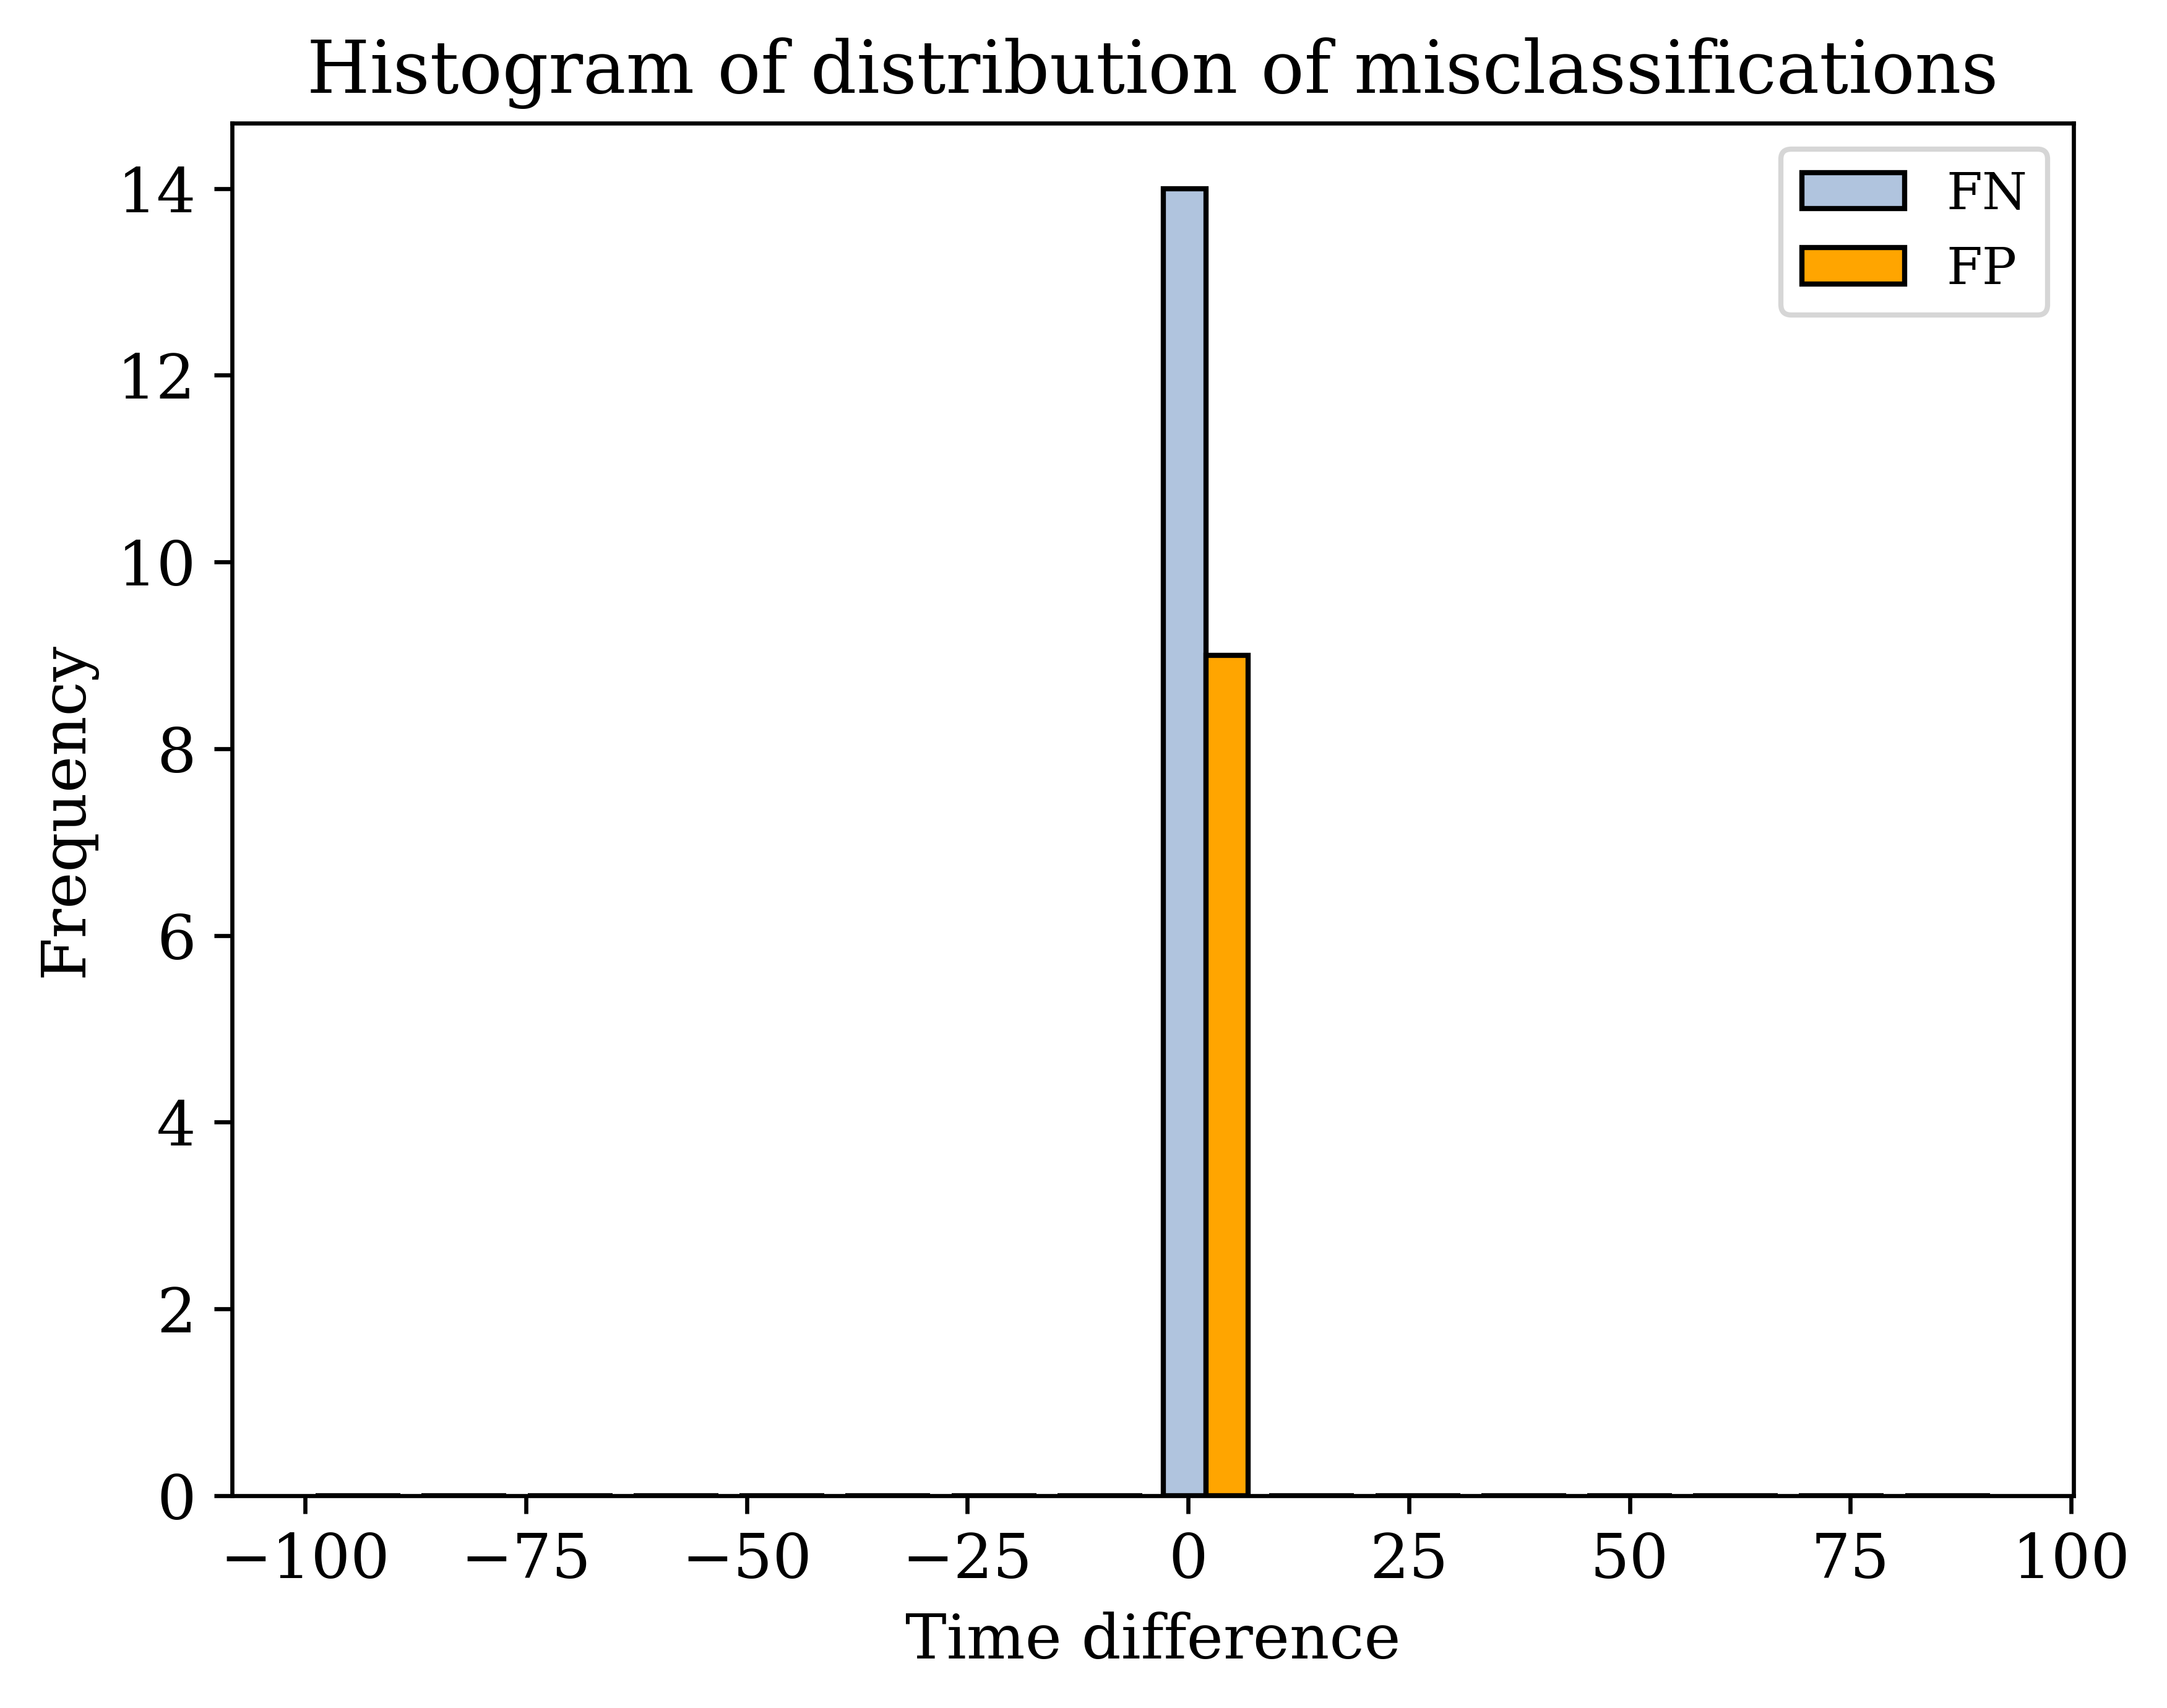

In [42]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/POS_extra_all_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [43]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_3175/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3175/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3175/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

cut  0.01  0.1  1  10  100  TO
FP      0    4  5   0    0   0
FN      4    7  3   0    0   0

#### Statistical tests

In [44]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [45]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
880            0           0  STATS  103-015-augF2-full1           orig   
1445           0           0    JOB       3c-augF2-full2           orig   
2331           0           0  STATS        048-127-augA1           orig   
3041           1           1  STATS              108-060           rewr   
4129           1           0   LSQB             q1-augA4           orig   

      orig(med)  rewr(med)  #relations  #conditions  #filters  ...  \
880    2.972437   2.976476           3            7         5  ...   
1445   0.077444   3.781730           4            7         3  ...   
2331   0.108263   0.234819           5           11         7  ...   
3041   0.825061   0.252393           6            8         3  ...   
4129   8.830530   9.380234          10            9         0  ...   

      median(container counts)  q75(container counts)  min(branching factors)  \
880                        1.0                    1.0                       2   
1445                       1.0                    1.0                       3   
2331                       1.0                    1.0                       4   
3041                       1.0                    1.0                       1   
4129                       1.0                    1.0                       1   

      max(branching factors)  mean(branching factors)  \
880                        2                 2.000000   
1445                       3                 3.000000   
2331                       4                 4.000000   
3041                       4                 2.500000   
4129                       2                 1.285714   

      median(branching factors)  q25(branching factors)  \
880                         2.0                    2.00   
1445                        3.0                    3.00   
2331                        4.0                    4.00   
3041                        2.5                    1.75   
4129                        1.0                    1.00   

      q75(branching factors)  diff rewr-orig  pred(med)  
880                     2.00        0.004039   2.972437  
1445                    3.00        3.704286   0.077444  
2331                    4.00        0.126556   0.108263  
3041                    3.25       -0.572668   0.252393  
4129                    1.50        0.549704   9.380234  

[5 rows x 39 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [46]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 269.0
P-value: 2.5686248577781875e-28


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [47]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 6.626209048786016
P-value: 1.0087360936567732e-10


#### Important features using Gini importance

In [48]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins  total cost  \
Importance    0.002064     0.011971  0.012905  0.005318    0.090839   

            min(table rows)  max(table rows)  mean(table rows)  \
Importance          0.02068         0.047394            0.0153   

            q25(table rows)  median(table rows)  ...  mean(container counts)  \
Importance         0.033637             0.01403  ...                0.015158   

            q25(container counts)  median(container counts)  \
Importance                    0.0                       0.0   

            q75(container counts)  min(branching factors)  \
Importance                    0.0                0.002536   

            max(branching factors)  mean(branching factors)  \
Importance                0.008717                 0.003111   

            median(branching factors)  q25(branching factors)  \
Importance                   0.005981                0.001904   

            q75(branching factors)  
Importance                0.000515  

[1 rows x 30 columns]

In [49]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
max(join rows)               0.343687
total cost                   0.090839
depth                        0.083228
q75(table rows)              0.081398
min(join rows)               0.053583
max(table rows)              0.047394
q75(join rows)               0.045777
q25(join rows)               0.037716
mean(join rows)              0.034713
q25(table rows)              0.033637
median(join rows)            0.024830
min(table rows)              0.020680
mean(table rows)             0.015300
mean(container counts)       0.015158
median(table rows)           0.014030
#filters                     0.012905
#conditions                  0.011971
max(branching factors)       0.008717
median(branching factors)    0.005981
#joins                       0.005318
mean(branching factors)      0.003111
max(container counts)        0.003008
min(branching factors)       0.002536
#relations                   0.002064
q25(branching factors)       0.001904
q75(branching factors)       0.000515
q75(container counts)        0.000000
median(container counts)     0.000000
q25(container counts)        0.000000
min(container counts)        0.000000

#### Visualization of the decision tree

In [50]:
clf.tree_.max_depth

18

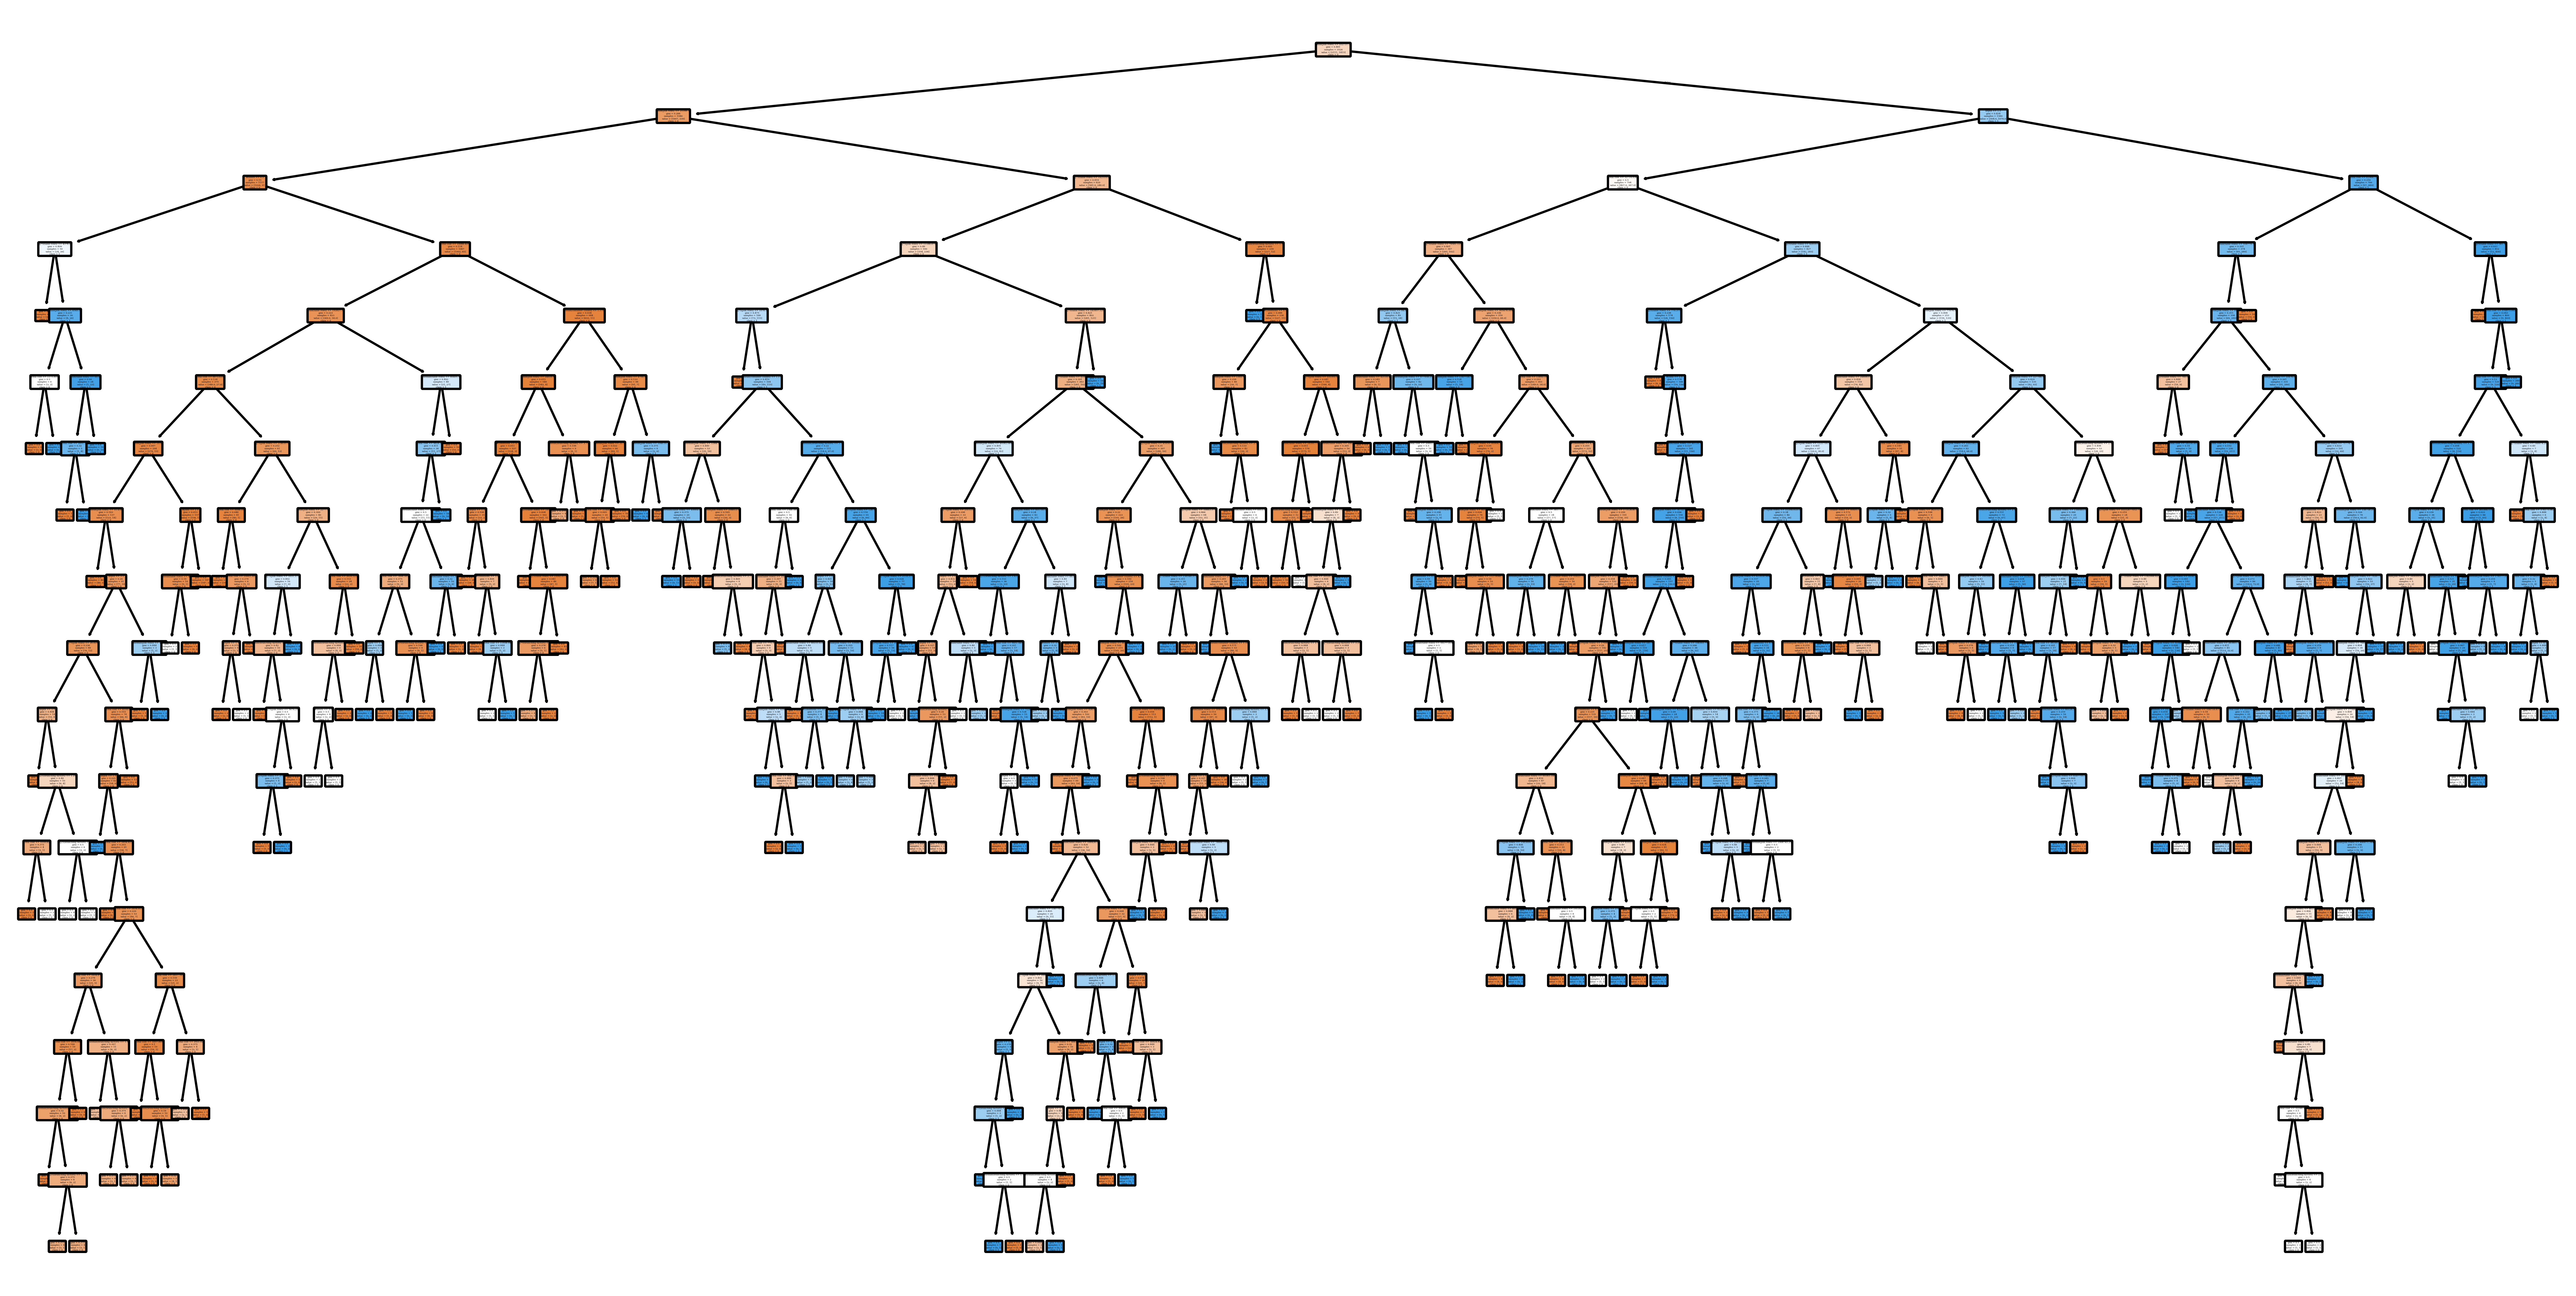

In [51]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/POS_extra_all_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_3175/3308351617.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_3175/3308351617.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_3175/3308351617.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

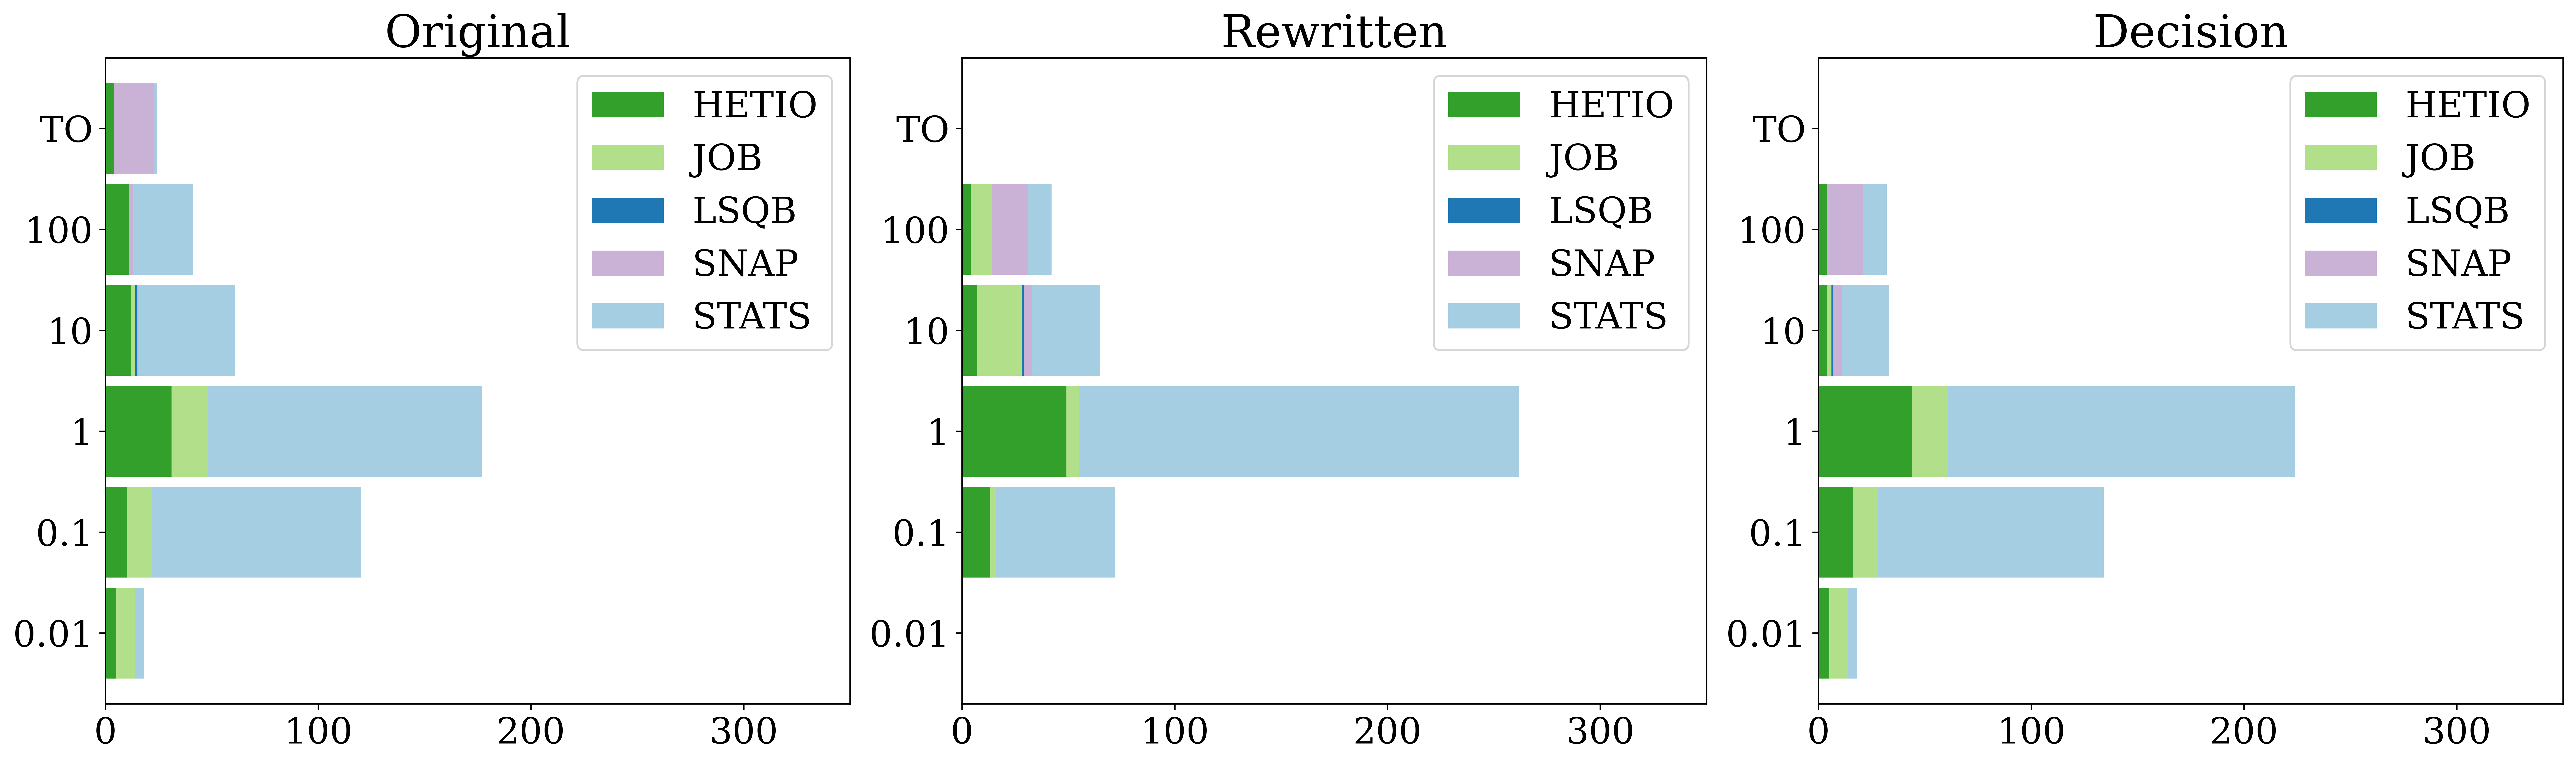

In [52]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/POS_extra_all_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_3175/1266179795.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_3175/1266179795.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_3175/1266179795.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

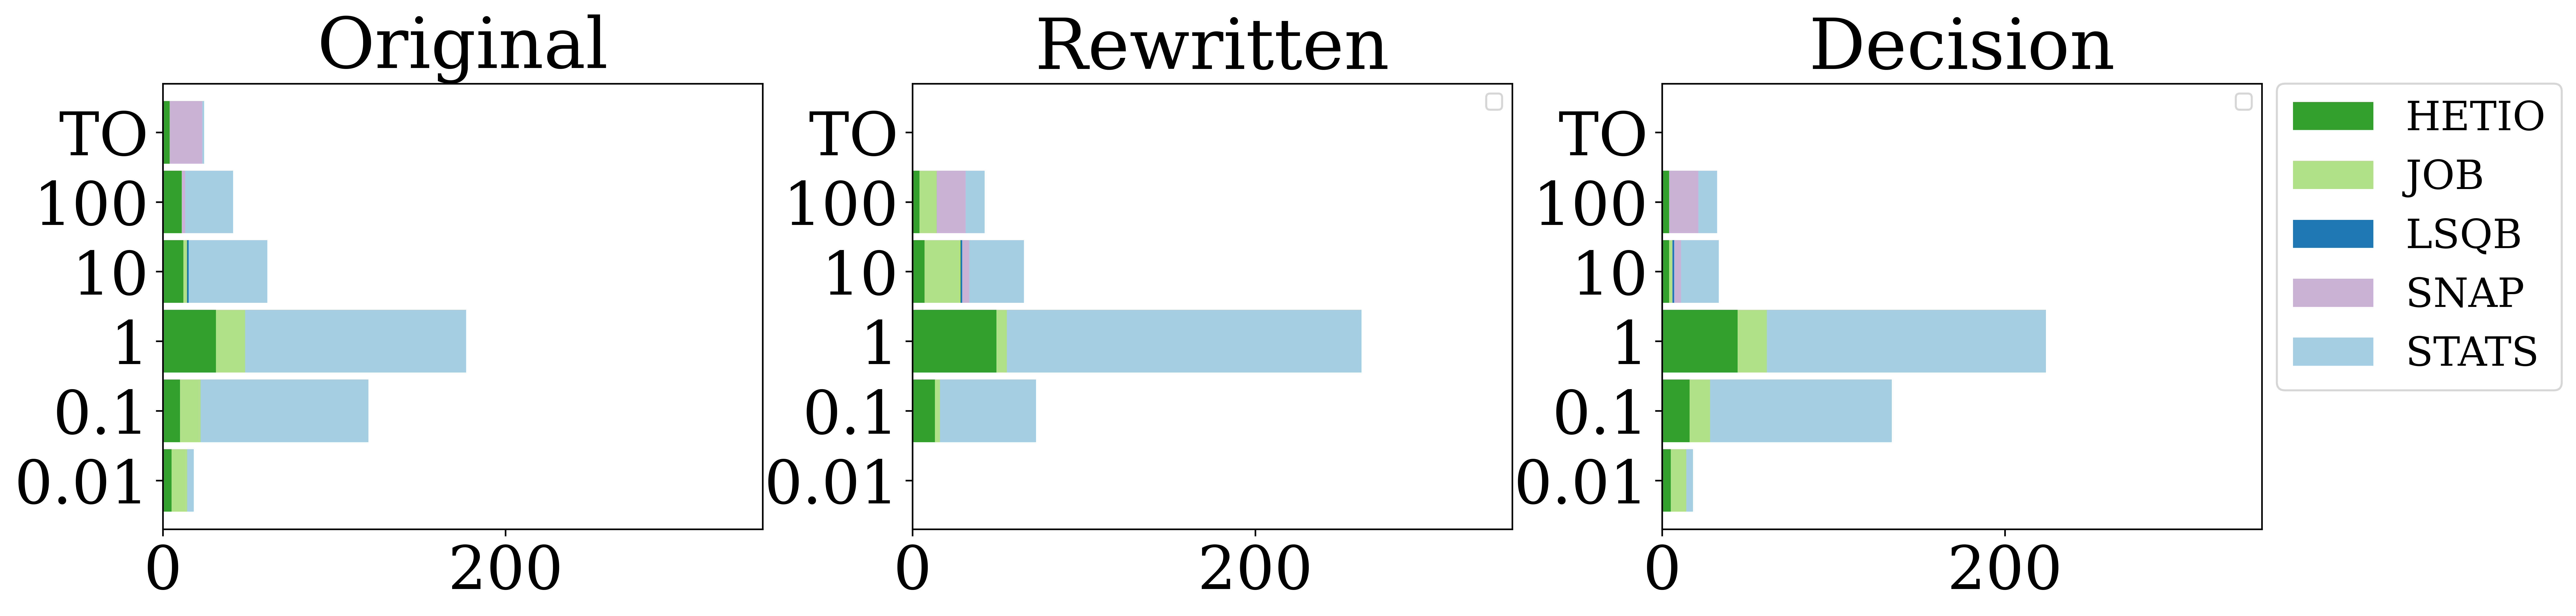

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/POS_extra_all_runtimes_color.png') 
plt.show()


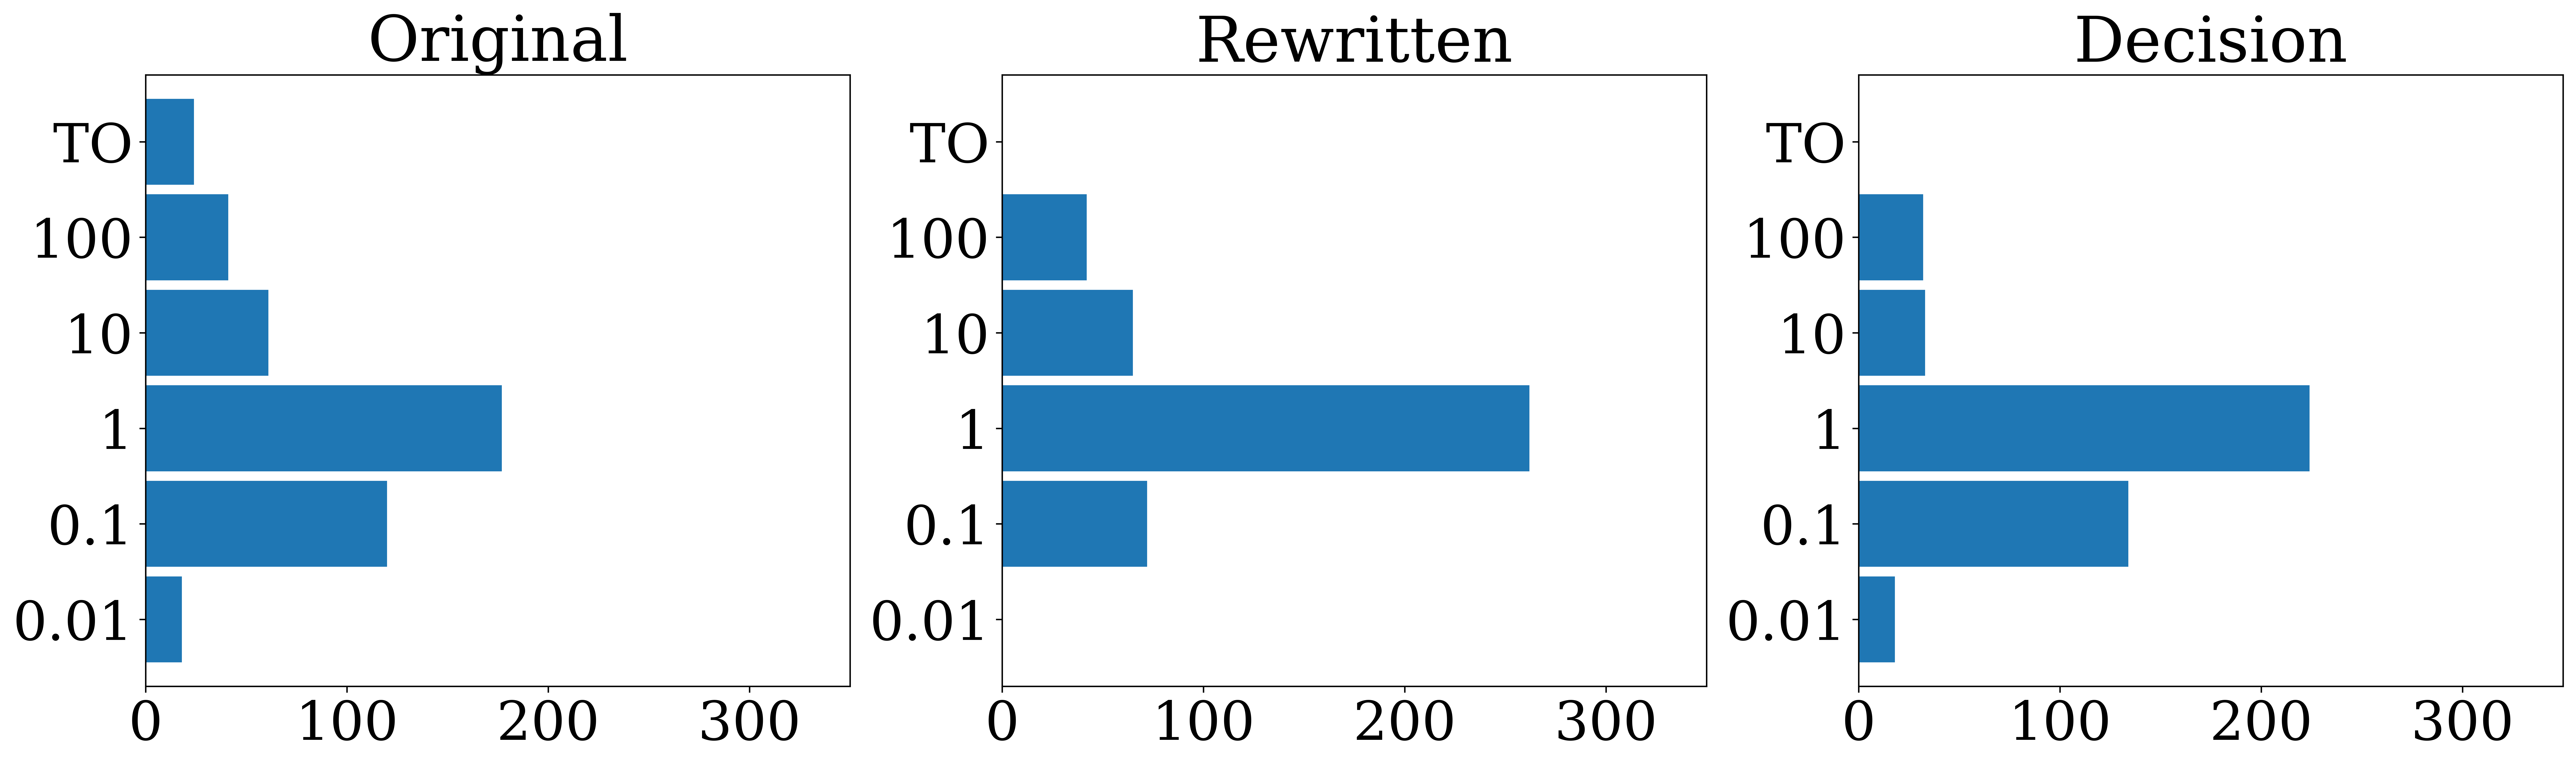

In [54]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/POS_extra_all_runtimes.png')
plt.show()